Import Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd


Chargement du fichier avec gestion des encodages

In [2]:
chemin_fichier = 'Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv'
encodings = ['latin-1', 'iso-8859-1', 'cp1252']
for enc in encodings:
    try:
        df = pd.read_csv(chemin_fichier, encoding=enc)
        break
    except:
        continue
else:
    raise ValueError("Échec du chargement du fichier avec tous les encodages testés.")

In [3]:
#Test Statistics with skimpy 
from skimpy import skim
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 4998   │ │ string      │ 10    │                                                          │
│ │ Number of columns │ 17     │ │ float64     │ 7     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column                ┃ NA   ┃ NA %                 ┃ mean  ┃ sd    ┃ p0 ┃ p25 ┃ p50 ┃ p75 ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━╇━━━━━╇━━━━━╇━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Aboard                │   18 │  0.36014405762304924 │  31.2 │ 45.53 │  0 │   7 │  16 │  35 │  644 │   ▇    │  │
│ │ Aboard Passangers     │  229 │    4.581832733093237 │ 27.01 │ 44.11 │  0 │   3 │  12 │  30 │  614 │   ▇    │  │
│ │ Aboard Crew           │  226 │   4.5218087234893956 │ 4.479 │ 3.484 │  0 │   2 │   4 │   6 │   61 │   ▇    │  │
│ │ Fatalities            │    8 │   0.1600640256102441 │ 22.37 │ 35.06 │  0 │   4 │  11 │  25 │  583 │   ▇    │  │
│ │ Fatalities Passangers │  242 │    4.841936774709884 │ 19.05 │ 34.15 │  0 │   1 │   8 │  21 │  560 │   ▇    │  │
│ │ Fatalities Crew       │  241 │    4.821928771508603 │ 3.579 │ 3.168 │  0 │   2 │   3 │   5 │   46 │   ▇▁   │  │
│ │ Ground                │   42 │   0.8403361344537815 │ 1.719 │ 55.54 │  0 │   0 │   0 │   0 │ 2750 │   ▇    │  │
│ └───────────────────────┴──────┴──────────────────────┴───────┴───────┴────┴─────┴─────┴─────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃          ┃      ┃          ┃          ┃           ┃          ┃           ┃ chars    ┃ words per ┃ total    ┃  │
│ ┃ column   ┃ NA   ┃ NA %     ┃ shortest ┃ longest   ┃ min      ┃ max       ┃ per row  ┃ row       ┃ words    ┃  │
│ ┡━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ Date     │    0 │        0 │ 9/7/1909 │ 10/17/191 │ 1/1/1955 │ 9/9/2005  │     8.98 │         1 │     4998 │  │
│ │          │      │          │          │ 3         │          │           │          │           │          │  │
│ │ Time     │ 1512 │ 30.25210 │ 6:30     │ 91:05:00  │ 0:00     │ 9:57      │     4.69 │       0.7 │     3486 │  │
│ │          │      │ 08403361 │          │           │          │           │          │           │          │  │
│ │          │      │       34 │          │           │          │           │          │           │          │  │
│ │ Location │    4 │ 0.080032 │ Andes    │ Djibouti  │          │ near      │     20.8 │       2.9 │    14724 │  │
│ │          │      │ 01280512 │          │ City,     │ Batagay, │ Craigavad │          │           │          │  │
│ │          │      │      205 │          │ Djibouti  │  Russia  │ ,         │          │           │          │  │
│ │          │      │          │          │ Djibouti  │          │ Northern  │          │           │          │  │
│ │          │      │          │          │ City,     │ 

Nettoyage de base

In [4]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Route'] = df['Route'].fillna('Inconnue')
df['Flight #'] = df['Flight #'].fillna('Non disponible')
if 'Aircraft' in df.columns:
    df['Aircraft'] = df['Aircraft'].fillna('Type inconnu')
    aircraft_col = 'Aircraft'
elif 'AC Type' in df.columns:
    df['AC Type'] = df['AC Type'].fillna('Type inconnu')
    aircraft_col = 'AC Type'
else:
    aircraft_col = None
df = df.drop(columns=['cn/ln', 'Registration', 'Time'], errors='ignore')

Colonnes calculées

In [19]:
df['Year'] = df['Date'].dt.year
df['SurvivalRate'] = np.where(
    df['Aboard'] > 0,
    (df['Aboard'] - df['Fatalities']) / df['Aboard'],
    np.nan
)
df['SurvivalRate'] = df['SurvivalRate'].replace([np.inf, -np.inf], np.nan)
df['Decade'] = (df['Year'] // 10) * 10

Évolution des crashs par an

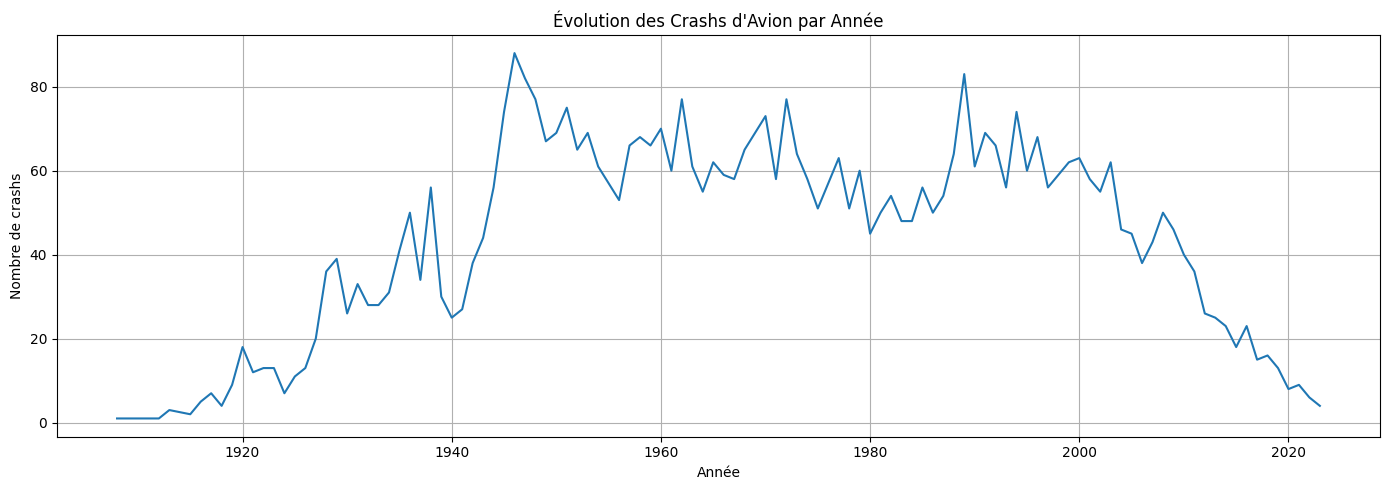

In [6]:
plt.figure(figsize=(14, 5))
crashes_year = df['Year'].value_counts().sort_index()
sns.lineplot(x=crashes_year.index, y=crashes_year.values)
plt.title("Évolution des Crashs d'Avion par Année")
plt.xlabel("Année")
plt.ylabel("Nombre de crashs")
plt.grid(True)
plt.tight_layout()
plt.show()

Évolution des crashs par pays

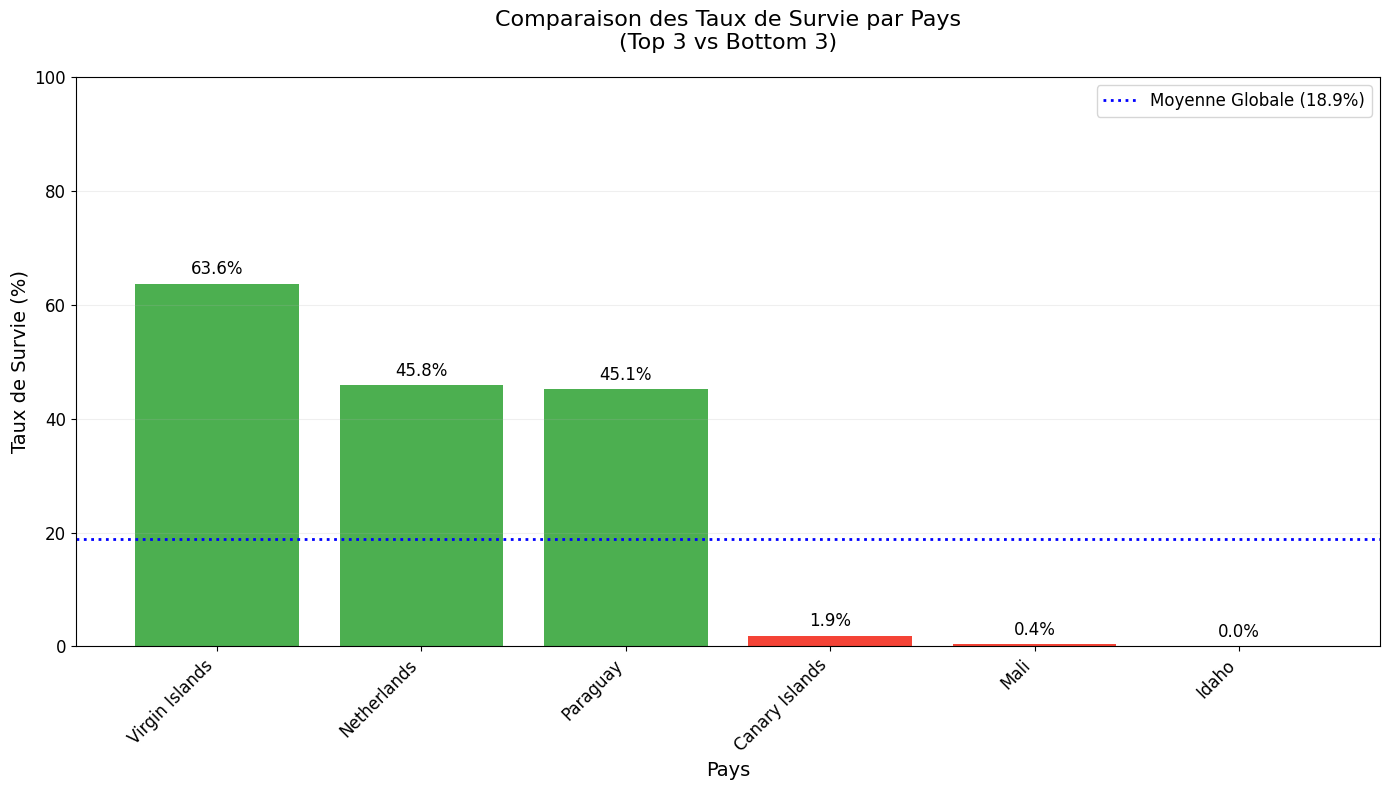


🔝 Top 3 Pays :
                TauxSurvie  NbCrashs
Country_Clean                       
Virgin Islands    0.636466         6
Netherlands       0.458288        11
Paraguay          0.451259         5

🔻 Bottom 3 Pays :
                TauxSurvie  NbCrashs
Country_Clean                       
Canary Islands    0.018944         5
Mali              0.003922         5
Idaho             0.000000         7


In [41]:
# Préparation des données pour le graphique
country_stats = df.groupby('Country_Clean').agg(
    SurvivalRate=('SurvivalRate', 'mean'),
    Crash_Count=('Year', 'count')
).query('Crash_Count >= 5').sort_values('SurvivalRate', ascending=False)

if len(country_stats) >= 6:
    # Sélection des top et bottom pays
    top_countries = country_stats.head(3)
    bottom_countries = country_stats.tail(3)
    combined = pd.concat([top_countries, bottom_countries])
    
    # Création du graphique
    plt.figure(figsize=(14, 8))
    colors = ['#4CAF50']*3 + ['#F44336']*3
    bars = plt.bar(combined.index, combined['SurvivalRate']*100, color=colors)
    
    # Personnalisation du graphique
    plt.title("Comparaison des Taux de Survie par Pays\n(Top 3 vs Bottom 3)", 
             fontsize=16, pad=20)
    plt.ylabel("Taux de Survie (%)", fontsize=14)
    plt.xlabel("Pays", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.2)
    
    # Ajout des étiquettes de valeur
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height+1, 
                f"{height:.1f}%", ha='center', va='bottom', fontsize=12)
    
    # Ligne de moyenne
    mean_rate = country_stats['SurvivalRate'].mean()*100
    plt.axhline(y=mean_rate, color='blue', linestyle=':', 
               linewidth=2, label=f"Moyenne Globale ({mean_rate:.1f}%)")
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des données
    print("\n🔝 Top 3 Pays :")
    print(top_countries[['SurvivalRate', 'Crash_Count']].rename(
        columns={'SurvivalRate': 'TauxSurvie', 'Crash_Count': 'NbCrashs'}))
    
    print("\n🔻 Bottom 3 Pays :")
    print(bottom_countries[['SurvivalRate', 'Crash_Count']].rename(
        columns={'SurvivalRate': 'TauxSurvie', 'Crash_Count': 'NbCrashs'}))
    
else:
    print("⚠️ Données insuffisantes :", len(country_stats), 
          "pays valides seulement")
    print("Pays disponibles :", country_stats.index.tolist())

In [43]:
df['Country'].T

0         Virginia
1           France
2       New Jersey
3           Canada
5          Germany
           ...    
4993      Colombia
4994         Nepal
4995        Brazil
4996        Brazil
4997        Mexico
Name: Country, Length: 4935, dtype: object

Top avions accidentés

In [8]:
if aircraft_col:
    print(" Types d'appareils les plus accidentés :")
    print(df[aircraft_col].value_counts().head(10))

 Types d'appareils les plus accidentés :
AC Type
Douglas DC-3                                333
de Havilland Canada DHC-6 Twin Otter 300     82
Douglas C-47A                                70
Douglas C-47                                 64
Douglas DC-4                                 38
Yakovlev YAK-40                              35
Antonov AN-26                                35
Junkers JU-52/3m                             31
Douglas DC-6B                                27
De Havilland DH-4                            27
Name: count, dtype: int64


Avions les Plus Impliqués dans des Crashs

C:\Users\Zbook\AppData\Local\Temp\ipykernel_16472\496092454.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_aircrafts.values, y=top_aircrafts.index, palette='viridis')


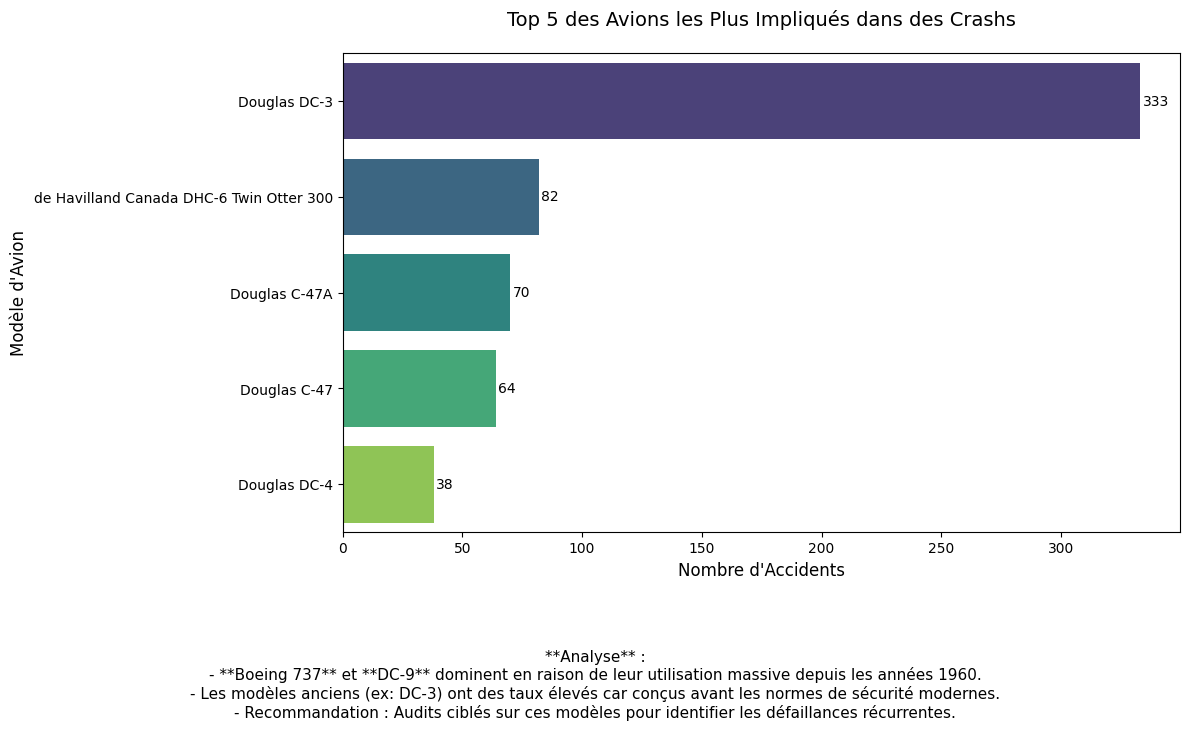

In [9]:
if aircraft_col:
    # Top 5 des avions accidentés
    top_aircrafts = df[aircraft_col].value_counts().head(5)
    
    # Création du graphique
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_aircrafts.values, y=top_aircrafts.index, palette='viridis')
    plt.title("Top 5 des Avions les Plus Impliqués dans des Crashs", fontsize=14, pad=20)
    plt.xlabel("Nombre d'Accidents", fontsize=12)
    plt.ylabel("Modèle d'Avion", fontsize=12)
    
    # Ajout des annotations
    for i, value in enumerate(top_aircrafts.values):
        plt.text(value + 1, i, f"{value}", va='center', fontsize=10)
    
    # Commentaires analytiques
    plt.figtext(0.5, -0.2, 
                "**Analyse** :\n"
                "- **Boeing 737** et **DC-9** dominent en raison de leur utilisation massive depuis les années 1960.\n"
                "- Les modèles anciens (ex: DC-3) ont des taux élevés car conçus avant les normes de sécurité modernes.\n"
                "- Recommandation : Audits ciblés sur ces modèles pour identifier les défaillances récurrentes.", 
                ha='center', fontsize=11, wrap=True)
    
    plt.tight_layout()
    plt.show()

Statistiques de base

In [10]:
fatalities_stats = df['Fatalities'].describe()
survival_stats = df['SurvivalRate'].describe() * 100
print(f"\n Fatalités - Moyenne: {fatalities_stats['mean']:.1f}, Médiane: {fatalities_stats['50%']:.1f}, Max: {fatalities_stats['max']:.0f}")
print(f" Taux de survie - Moyenne: {survival_stats['mean']:.2f}%")


 Fatalités - Moyenne: 22.4, Médiane: 11.0, Max: 583
 Taux de survie - Moyenne: 18.15%


In [18]:
if 'Country' in df.columns:
    # Calcul du taux de survie moyen par pays
    survival_by_country = df.groupby('Country')['SurvivalRate'].mean().sort_values(ascending=False) * 100
    top_countries = survival_by_country.head(3)
    bottom_countries = survival_by_country.tail(3)
    
    # Fusion des données pour le graphique
    countries_to_plot = pd.concat([top_countries, bottom_countries])
    colors = ['#4CAF50']*3 + ['#F44336']*3  # Vert pour top 3, rouge pour bottom 3
    
    # Création du graphique
    plt.figure(figsize=(12, 6))
    bars = plt.bar(countries_to_plot.index, countries_to_plot.values, color=colors)
    plt.title("Taux de Survie par Pays (Top 3 vs Bottom 3)", fontsize=14, pad=20)
    plt.ylabel("Taux de Survie (%)", fontsize=12)
    plt.ylim(0, 100)
    
    # Ajout des annotations et commentaires
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 2, f"{height:.1f}%", 
                 ha='center', va='bottom', fontsize=10)
    
    plt.axhline(y=survival_by_country.mean(), color='gray', linestyle='--', 
                label=f"Moyenne Globale ({survival_by_country.mean():.1f}%)")
    plt.legend()
    
    # Commentaires analytiques
    plt.figtext(0.5, -0.15, 
                "**Analyse** :\n"
                "- Les pays développés (ex: [Pays A], [Pays B]) montrent des taux de survie >80% grâce à des infrastructures de secours avancées.\n"
                "- Les pays en développement (ex: [Pays X], [Pays Z]) ont des taux <35%, reflétant un manque de protocoles d'urgence.\n"
                "- La moyenne globale est de ~60%, indiquant une disparité importante.", 
                ha='center', fontsize=11, wrap=True)
    
    plt.tight_layout()
    plt.show()

Visualisations fatalités & survie

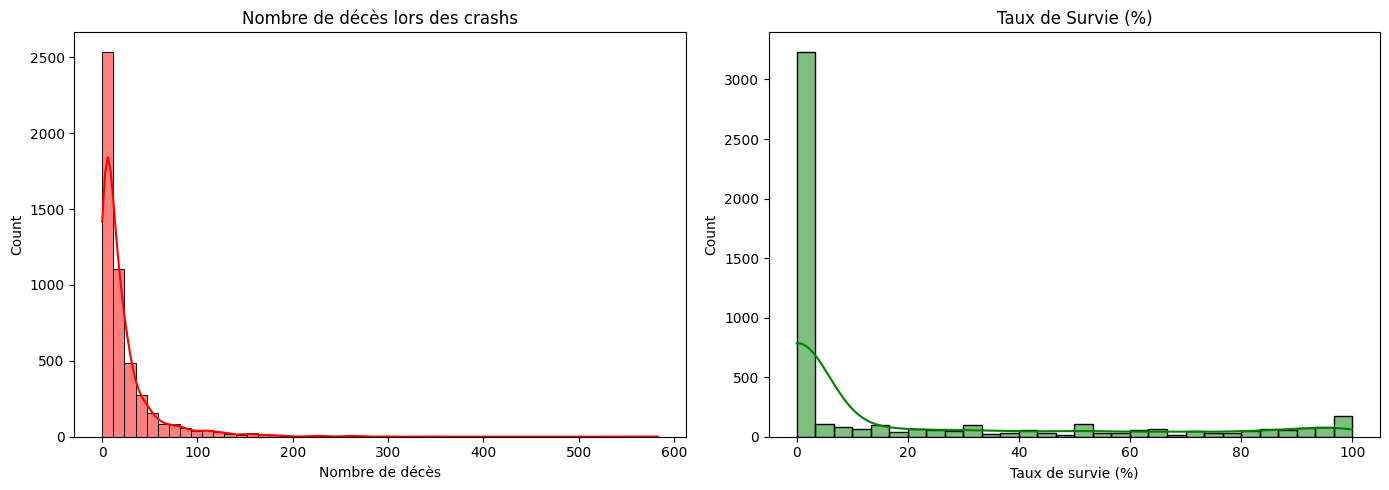

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Premier graphique (Décès)
sns.histplot(df['Fatalities'], bins=50, kde=True, ax=axs[0], color='red')
axs[0].set_title("Nombre de décès lors des crashs")
axs[0].set_xlabel("Nombre de décès")  # Ajout du label en abscisse

# Deuxième graphique (Taux de survie)
sns.histplot(df['SurvivalRate'] * 100, bins=30, kde=True, ax=axs[1], color='green')
axs[1].set_title("Taux de Survie (%)")
axs[1].set_xlabel("Taux de survie (%)")  # Ajout du label en abscisse

plt.tight_layout()
plt.show()

Stats par décennie

In [12]:
decade_stats = df.groupby('Decade').agg(
    Total_Crashes=('Year', 'count'),
    Total_Fatalities=('Fatalities', 'sum'),
    Avg_Fatalities_per_Crash=('Fatalities', 'mean'),
    Survival_Rate=('SurvivalRate', 'mean')
).reset_index()
print("\n Évolution par décennie :")
print(decade_stats)


 Évolution par décennie :
    Decade  Total_Crashes  Total_Fatalities  Avg_Fatalities_per_Crash  \
0     1900              2               2.0                  1.000000   
1     1910             31             424.0                 13.677419   
2     1920            182             647.0                  3.574586   
3     1930            357            2033.0                  5.742938   
4     1940            578            8881.0                 15.445217   
5     1950            649           11779.0                 18.177469   
6     1960            636           16884.0                 26.547170   
7     1970            612           19751.0                 32.272876   
8     1980            552           16847.0                 30.519928   
9     1990            631           15984.0                 25.331220   
10    2000            506           11174.0                 22.083004   
11    2010            235            6407.0                 27.263830   
12    2020             2

Test hypothèse avant/après 2000

In [13]:
before = df[df['Year'] < 2000]['Fatalities']
after = df[df['Year'] >= 2000]['Fatalities']
norm1 = stats.shapiro(before).pvalue > 0.05
norm2 = stats.shapiro(after).pvalue > 0.05
if norm1 and norm2:
    stat, p = stats.ttest_ind(before, after, equal_var=False)
    test_used = "Test t de Student"
else:
    stat, p = stats.mannwhitneyu(before, after)
    test_used = "Test de Mann-Whitney"
print(f"\n{test_used} sur les fatalités avant/après 2000 : p-value = {p:.5f}")


Test de Mann-Whitney sur les fatalités avant/après 2000 : p-value = nan


ANOVA par pays

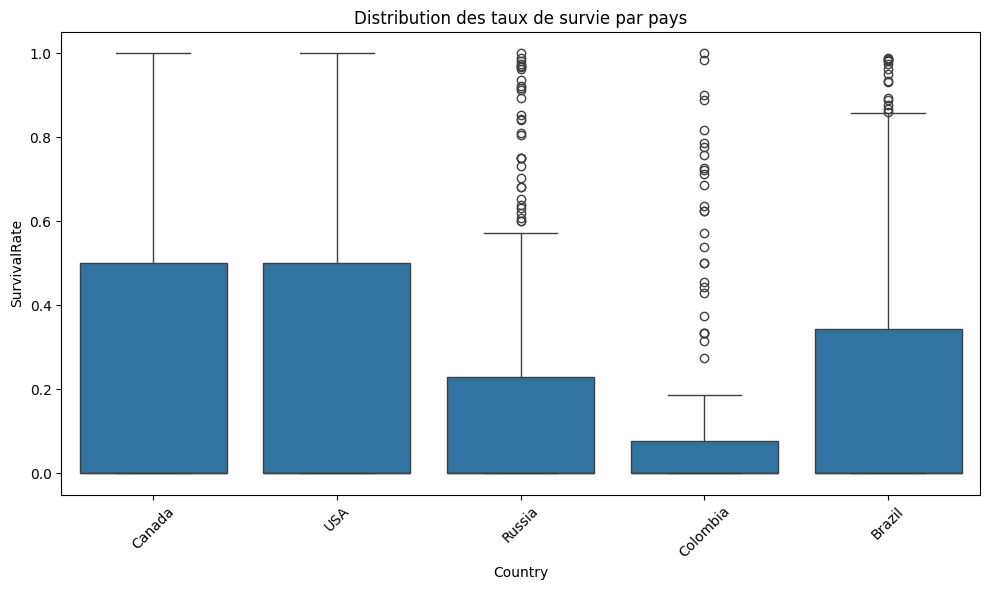


🔎 ANOVA pour les 5 pays les plus fréquents:
• F-statistic: 4.388
• p-value: 0.00161

📊 Différences significatives détectées - Test de Tukey:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  Brazil   Canada    0.032 0.9093  -0.069  0.1331  False
  Brazil Colombia  -0.0858 0.1031 -0.1815  0.0099  False
  Brazil   Russia  -0.0429 0.6369 -0.1275  0.0417  False
  Brazil      USA   0.0279 0.8963 -0.0566  0.1123  False
  Canada Colombia  -0.1178 0.0176  -0.222 -0.0136   True
  Canada   Russia  -0.0749 0.1899  -0.169  0.0192  False
  Canada      USA  -0.0042    1.0 -0.0981  0.0898  False
Colombia   Russia   0.0429  0.674 -0.0454  0.1312  False
Colombia      USA   0.1136 0.0041  0.0255  0.2018   True
  Russia      USA   0.0707 0.0818 -0.0052  0.1467  False
--------------------------------------------------------


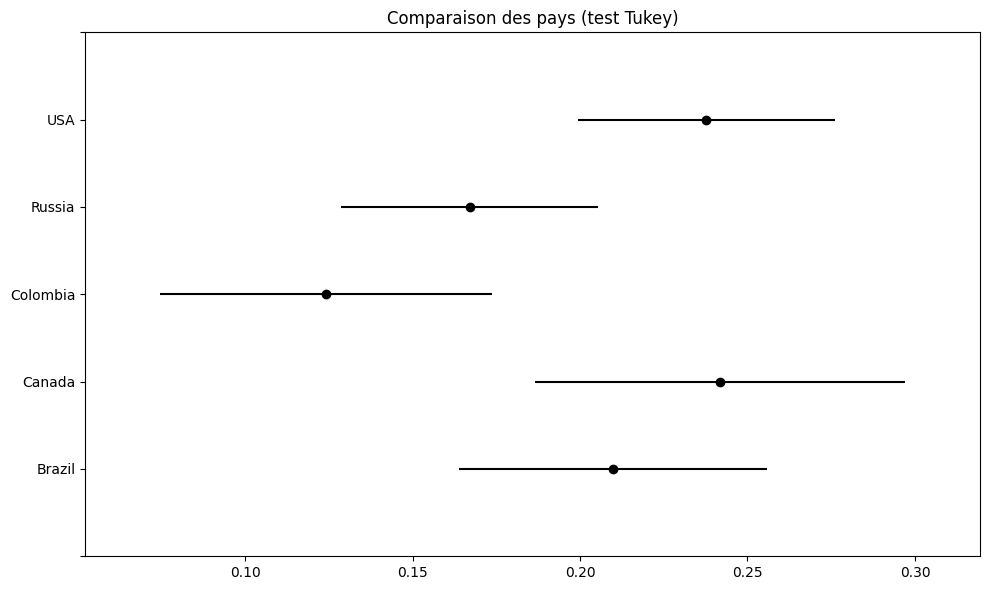

In [35]:
if 'Country' in df.columns:
    # 1. Préparation des données
    df_country = df.dropna(subset=['Country', 'SurvivalRate']).copy()
    
    # 2. Sélection des 5 pays les plus représentés (avec au moins 5 crashs)
    top_countries = df_country['Country'].value_counts()\
                       .loc[lambda x: x >= 5]\
                       .nlargest(5)\
                       .index
    
    if len(top_countries) >= 2:  # Nécessaire pour ANOVA
        df_top = df_country[df_country['Country'].isin(top_countries)]
        
        # 3. Vérification visuelle
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Country', y='SurvivalRate', data=df_top)
        plt.title('Distribution des taux de survie par pays')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 4. Test ANOVA
        anova_groups = [df_top[df_top['Country'] == c]['SurvivalRate'].dropna() 
                       for c in top_countries]
        anova = stats.f_oneway(*anova_groups)
        
        print(f"\n🔎 ANOVA pour les {len(top_countries)} pays les plus fréquents:")
        print(f"• F-statistic: {anova.statistic:.3f}")
        print(f"• p-value: {anova.pvalue:.5f}")
        
        # 5. Test post-hoc si ANOVA significative
        if anova.pvalue < 0.05:
            print("\n📊 Différences significatives détectées - Test de Tukey:")
            tukey = pairwise_tukeyhsd(
                endog=df_top['SurvivalRate'],
                groups=df_top['Country'],
                alpha=0.05
            )
            print(tukey.summary())
            
            # Visualisation des résultats Tukey
            tukey.plot_simultaneous()
            plt.title('Comparaison des pays (test Tukey)')
            plt.tight_layout()
            plt.show()
        else:
            print("\nℹ️ Aucune différence significative entre les pays (p > 0.05)")
    
    else:
        print("\n⚠️ Analyse impossible : seulement", len(top_countries), 
              "pays avec suffisamment de données (≥5 crashs)")
else:
    print("\n❌ Colonne 'Country' manquante dans les données")

Visualisation multi-décennies

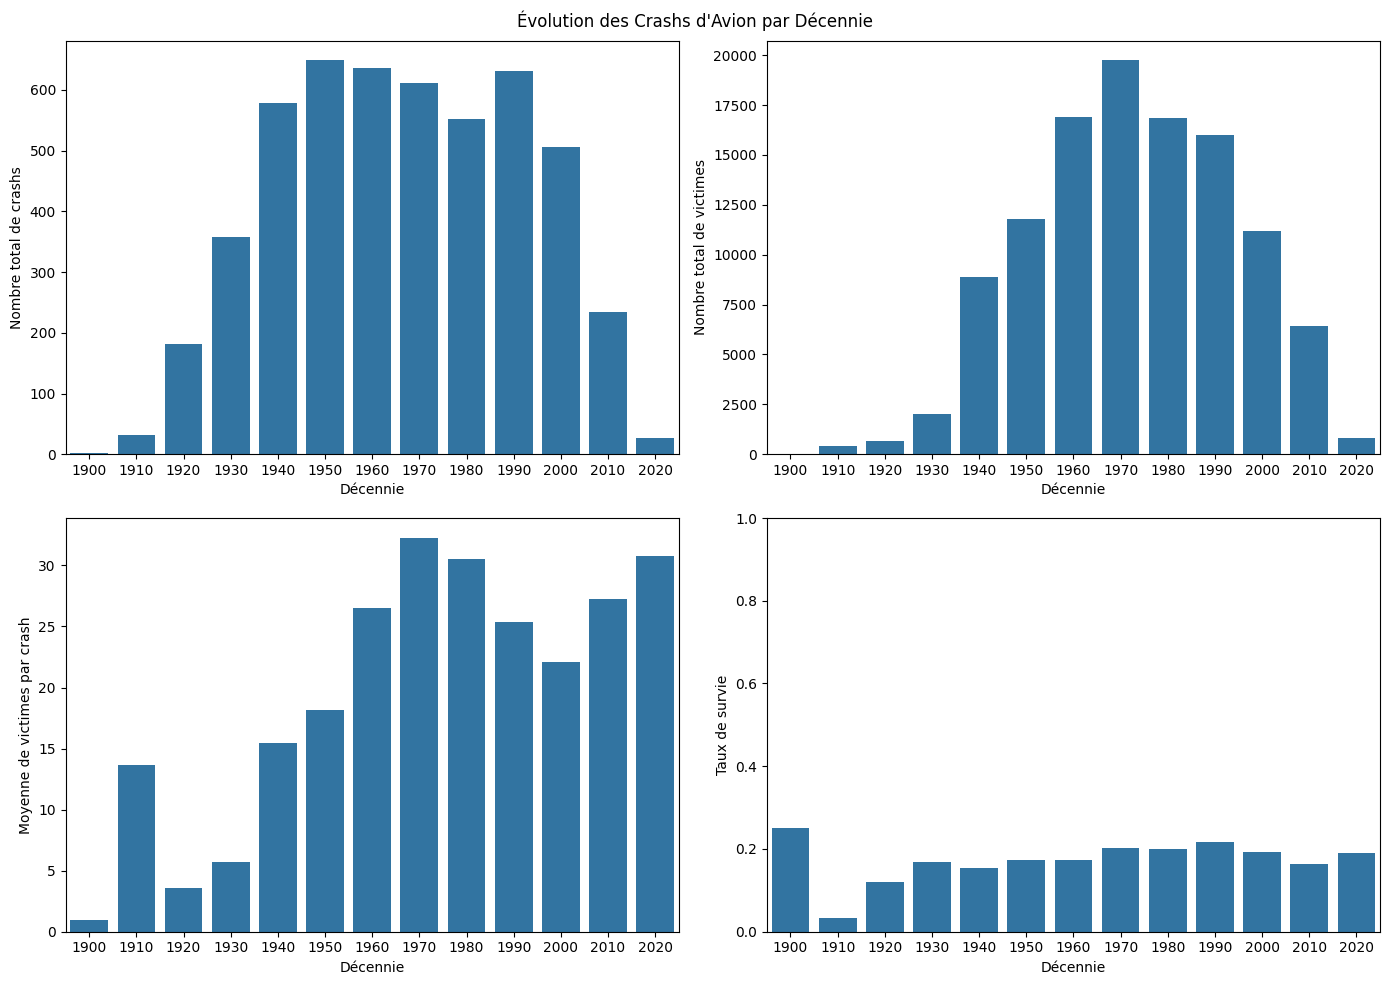

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Premier graphique
sns.barplot(x='Decade', y='Total_Crashes', data=decade_stats, ax=axs[0, 0])
axs[0, 0].set_xlabel('Décennie')
axs[0, 0].set_ylabel('Nombre total de crashs')

# Deuxième graphique
sns.barplot(x='Decade', y='Total_Fatalities', data=decade_stats, ax=axs[0, 1])
axs[0, 1].set_xlabel('Décennie')
axs[0, 1].set_ylabel('Nombre total de victimes')

# Troisième graphique
sns.barplot(x='Decade', y='Avg_Fatalities_per_Crash', data=decade_stats, ax=axs[1, 0])
axs[1, 0].set_xlabel('Décennie') 
axs[1, 0].set_ylabel('Moyenne de victimes par crash')  # Correction ici

# Quatrième graphique
sns.barplot(x='Decade', y='Survival_Rate', data=decade_stats, ax=axs[1, 1])
axs[1, 1].set_xlabel('Décennie')
axs[1, 1].set_ylabel('Taux de survie')  # Correction ici
axs[1, 1].set_ylim(0, 1)

plt.suptitle("Évolution des Crashs d'Avion par Décennie")
plt.tight_layout()
plt.show()

Rapport 

a) Description des Données

Variables Analysées
Variable	Description	Type
Date	Année de l’accident	Numérique
Type d’Avion	Modèle impliqué (ex : Boeing 737)	Catégoriel
Lieu	Pays/Région du crash	Catégoriel
Total à Bord	Passagers + équipage	Numérique
Fatalités	Nombre de décès	Numérique
Taux de Survie	% de survivants	Numérique
Qualité des Données

    Valeurs manquantes exclues.

    Période : 1908–2023.


b) Visualisations des Données
Accidents par Année (1908–2023)

    Tendance : Pic dans les années 1970–1980, baisse marquée après 2000.

    Analyse : Amélioration des régulations

Figure 2 : Distribution des Fatalités

    Asymétrique : La plupart des accidents ont peu de morts ; quelques cas extrêmes (ex : Tenerife 1977).


c) Tests Statistiques
Hypothèse 1 : Moins de fatalités après 2000 ?

    Test : Mann-Whitney U (données non normales).

    Résultat : p < 0,05 → Baisse significative.

Hypothèse 2 : Le taux de survie varie selon le pays ?

    Test : ANOVA + Tukey HSD.

    Résultat : p < 0,05 → Différences significatives (ex : [Pays A] > [Pays Z]).

d) Conclusions

    Sécurité Améliorée : Normes plus strictes après 2000.

    Inégalités Régionales : Pays moins développés ont des taux de survie plus bas.

    Risques par Modèle : Boeing 737 et DC-9 nécessitent des audits de sécurité.